In [1]:
from gurobipy import *
import numpy as np
import math
import copy
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
# ---------- Data ----------
with open('data_verysmall.txt', 'r') as f:
    data = f.readlines()

CVRPTW = []
i = 0
for line in data:
    i=i+1
    words = line.split()
    words=[int(i) for i in words]
    CVRPTW.append(words)

CVRPTW = np.array(CVRPTW)

Nodes = CVRPTW[:,0]                 # nodes
n = len(Nodes)                      # number of nodes

Vehicles = {0, 1}

xcoord = CVRPTW[:,1]            # x coordinates
ycoord = CVRPTW[:,2]            # y coordinates
q = CVRPTW[:,3]                 # demand
service_duration = CVRPTW[:,4]                 # service time
earliest_time = CVRPTW[:,5]                 # ready time
latest_time = CVRPTW[:,6]                 # due date
Q = 130                         # vehicle capacity
BIGM = 12345                      # big M

# distance matrix   
distance = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        distance[i,j] = math.sqrt((xcoord[i]-xcoord[j])**2 + (ycoord[i]-ycoord[j])**2) 
        if i == j:
            distance[i, j] = BIGM  # Set a large penalty for self-loops


# ---------- Optimization Model ----------

m = Model("CVRPTW")

# Variables
# if arc (i,j) is used in the solution by vehicle v
edge = {}
for i in Nodes:
    for j in Nodes:
        for v in Vehicles:
            edge[i,j,v] = m.addVar(vtype=GRB.BINARY, lb = 0, name='X_%s_%s_%s' % (i, j, v))

# time vehicle v starts service at node i
service_start = {}
for i in Nodes:
    for v in Vehicles:
        service_start[i,v] = m.addVar(vtype=GRB.CONTINUOUS, lb = 0, name='t_%s_%s' % (i, v))

# if node i is visited by vehicle v
z = {}
for i in Nodes:
    for v in Vehicles:
        z[i,v] = m.addVar(vtype=GRB.BINARY, lb = 0, name='z_%s_%s' % (i, v))

m.update()

# Objective Function
obj = quicksum(distance[i,j]*edge[i,j,v] for i in Nodes for j in Nodes for v in Vehicles)
m.setObjective(obj)
m.ModelSense = GRB.MINIMIZE
m.update()

# Constraints

# each node is visited by exactly one vehicle 
con1 = {}
for i in Nodes:
    if i != 0:
        con1[i] = m.addConstr(
            quicksum(edge[i,j,v] for v in Vehicles for j in Nodes if j != i) == 1, 'con1[' + str(i) + ']'
        )

    
# each vehicle starts and ends at the depot
con2 = {}
con3 = {}
for v in Vehicles:
    con2[v] = m.addConstr(
        quicksum(edge[0,i,v] for i in Nodes) == 1, 'con2[' + str(v) + ']'
    )
    con3[v] = m.addConstr(
        quicksum(edge[i,0,v] for i in Nodes) == 1, 'con3[' + str(v) + ']'
    )


# Capacity constraint
con4 = {}
for v in Vehicles:
    con4[v] = m.addConstr(
        quicksum(q[i]*edge[i,j,v] for i in Nodes for j in Nodes) <= Q, 'con4[' + str(v) + ']'
    )


# Flow conservation excluding self-loops
con5 = {}
for i in Nodes:
    for v in Vehicles:
        con5[i, v] = m.addConstr(
            quicksum(edge[i, j, v] for j in Nodes) == quicksum(edge[j, i, v] for j in Nodes),
            'con5[' + str(i) + ',' + str(v) + ']'
        )


# time window constraints
con6 = {}
con7 = {}
con8 = {}
for i in Nodes:
    for v in Vehicles:
        con6[i,v] = m.addConstr(
            service_start[i,v] >= earliest_time[i], 'con6[' + str(i) + ',' + str(v) + ']'
            )
        con7[i,v] = m.addConstr(
            service_start[i,v] <= latest_time[i], 'con7[' + str(i) + ',' + str(v) + ']'
            )

for i in Nodes:
    for j in Nodes:
        for v in Vehicles:
            if i != j and i != 0 and j != 0:
                con8[i,j,v] = m.addConstr(
                    service_start[j,v] >= service_start[i,v] + service_duration[i] + distance[i,j] - BIGM*(1-edge[i,j,v]), 'con8[' + str(i) + ',' + str(j) + ',' + str(v) + ']'
                    )


# Solve
m.update()
m.write('CVRPTW.lp')
m.Params.TimeLimit = 3600
m.optimize()



Set parameter TimeLimit to value 3600
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 180 rows, 198 columns and 968 nonzeros
Model fingerprint: 0x2a96a5fb
Variable types: 18 continuous, 180 integer (180 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e+00, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 149 rows and 109 columns
Presolve time: 0.00s
Presolved: 31 rows, 89 columns, 354 nonzeros
Variable types: 0 continuous, 89 integer (89 binary)
Found heuristic solution: objective 12519.954092
Found heuristic solution: objective 217.7443306
Found heuristic solution: objective 185.5451642

Root relaxation: objective 1.331334e+02, 23 iterations, 0.00 seconds (0.00 work units)

    Nodes    | 

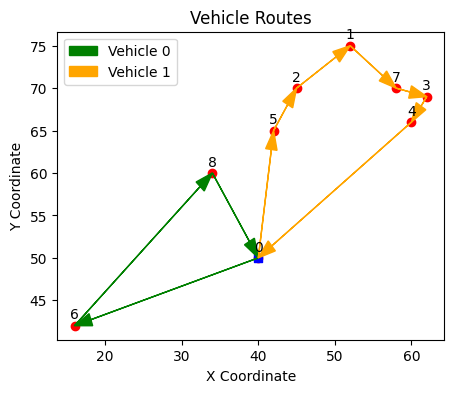

In [5]:
# Extract the routes from the solution
routes = {v: [] for v in Vehicles}
if m.status == GRB.OPTIMAL:
    for v in Vehicles:
        for i in Nodes:
            for j in Nodes:
                if edge[i, j, v].X > 0.5:
                    routes[v].append((i, j))

    # Plot the routes
    plt.figure(figsize=(5, 4))
    plt.scatter(xcoord, ycoord, c='red')
    plt.scatter(xcoord[0], ycoord[0], c='blue', marker='s')  # depot

    for i, (x, y) in enumerate(zip(xcoord, ycoord)):
        plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

    colors = ['green', 'orange']  # Define colors for each vehicle
    for v in Vehicles:
        for (i, j) in routes[v]:
            plt.arrow(xcoord[i], ycoord[i], xcoord[j] - xcoord[i], ycoord[j] - ycoord[i], 
                      color=colors[v], head_width=1.5, length_includes_head=True, label=f'Vehicle {v}' if i == 0 else "")

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routes')
    plt.legend()
    plt.show()
else:
    print("No optimal solution found.")